### exploratory analysis of the gbyk experiment

click [here](https://www.notion.so/oliveiracaio/in-progress-exploratory-analysis-of-the-gbyk-experiment-17ca2d01e2ff80b28fa1e28899d36bd3?pvs=25) to access the corresponding notion page.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

import motorlab as ml

In [ ]:
os.chdir(Path().resolve().parent)

In [ ]:
sns.set_context("poster", font_scale=2.0)
sns.set_style("white")
sns.set_theme(style="ticks")

PLOTS_DIR = Path("plots/gbyk_stats/")
PALETTE = sns.color_palette(
    [
        sns.xkcd_rgb["electric pink"],
        sns.xkcd_rgb["neon blue"],
        sns.xkcd_rgb["bright red"],
        sns.xkcd_rgb["blue"],
        sns.xkcd_rgb["black"],
        sns.xkcd_rgb["mango"],
    ]
)
SESSIONS = ml.config.gbyk_sessions
DATA_DIR = Path("data/gbyk")

In [ ]:
trial_info = dict()

for session in SESSIONS:
    trial_info[session] = []
    trials_dir = DATA_DIR / session / "intervals"
    for trial in sorted(trials_dir.iterdir()):
        with trial.open("r") as f:
            meta = yaml.safe_load(f)
            meta["num_frames"] = meta["num_frames"] // 50
            meta["first_frame_idx"] = meta["first_frame_idx"] // 50
            trial_info[session].append(meta)

In [ ]:
df = pd.DataFrame(
    [
        {**trial, "session": session}
        for session, trials in trial_info.items()
        for trial in trials
    ]
)
df

In [ ]:
summary = (
    df.groupby(["session", "type", "side"])
    .agg(
        count=("side", "size"),
        mistake=(
            "reward",
            lambda x: (
                df.loc[x.index, "side"] != df.loc[x.index, "reward"]
            ).sum(),
        ),
    )
    .unstack(["type", "side"], fill_value=0)
    .reset_index()
)

summary.columns = ["session"] + [
    f"{t} {c} {stat}" for stat, t, c in summary.columns[1:]
]
summary.to_csv("gbyk_stats.csv", index=False)
summary

### histograms of trial duration

In [ ]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 4 * nrows),
    sharex=True,
    sharey=True,
)

df["duration"] = df["num_frames"] * 50 / 1000  # Convert to seconds
hue_order = ["L", "R"]
side_palette = {"L": PALETTE[0], "R": PALETTE[1]}

for i, session in enumerate(SESSIONS):
    axs[i // ncols, i % ncols].set_title(session, pad=7)

    g = sns.histplot(
        df[(df["session"] == session) & (df["type"] != "homing")],
        x="duration",
        hue="side",
        ax=axs[i // ncols, i % ncols],
        palette=side_palette,
        legend=True,
    )

    legend = axs[i // ncols, i % ncols].get_legend()
    handles = legend.get_patches()
    labels = [t.get_text() for t in legend.get_texts()]
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: x[1])
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    axs[i // ncols, i % ncols].legend(sorted_handles, sorted_labels)

for ax in axs.flat:
    ax.set_xlabel("duration [s]")

plt.savefig(
    PLOTS_DIR / "histogram_trials_side.svg",
    bbox_inches="tight",
)
plt.show()

In [ ]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 3 * nrows),
    sharex=True,
    sharey=True,
)

hue_order = ["precue", "gbyk"]
type_palette = {"precue": PALETTE[0], "gbyk": PALETTE[1]}

for i, session in enumerate(SESSIONS):
    axs[i // ncols, i % ncols].set_title(session, pad=7)

    g = sns.histplot(
        df[(df["session"] == session) & (df["type"] != "homing")],
        x="duration",
        hue="type",
        ax=axs[i // ncols, i % ncols],
        palette=type_palette,
        legend=True,
    )

    legend = axs[i // ncols, i % ncols].get_legend()
    handles = legend.get_patches()
    labels = [t.get_text() for t in legend.get_texts()]
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: x[1])
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    axs[i // ncols, i % ncols].legend(sorted_handles, sorted_labels)

for ax in axs.flat:
    ax.set_xlabel("duration [s]")

plt.savefig(
    PLOTS_DIR / "histogram_trials_type.svg",
    bbox_inches="tight",
)
plt.show()

In [ ]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 3 * nrows),
    sharex=True,
    sharey=True,
)

df["type_side"] = df["type"] + " " + df["side"]
hue_order = ["precue L", "precue R", "gbyk L", "gbyk R"]
combined_palette = {
    "precue L": PALETTE[2],
    "precue R": PALETTE[3],
    "gbyk L": PALETTE[4],
    "gbyk R": PALETTE[5],
}

for i, session in enumerate(SESSIONS):
    axs[i // ncols, i % ncols].set_title(session, pad=7)

    g = sns.histplot(
        df[(df["session"] == session) & (df["type"] != "homing")],
        x="duration",
        hue="type_side",
        ax=axs[i // ncols, i % ncols],
        palette=combined_palette,
        legend=True,
    )

    legend = axs[i // ncols, i % ncols].get_legend()
    handles = legend.get_patches()
    labels = [t.get_text() for t in legend.get_texts()]
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: x[1])
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    axs[i // ncols, i % ncols].legend(sorted_handles, sorted_labels)

for ax in axs.flat:
    ax.set_xlabel("duration [s]")

plt.savefig(
    PLOTS_DIR / "histogram_trials_condition.svg",
    bbox_inches="tight",
)
plt.show()

### traces of the center of mass during trials

In [ ]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 3 * nrows),
    sharex=True,
    sharey=True,
)

tile_size = ml.room.y_size / ml.room.y_divisions
ylines = [(i + 1) * tile_size for i in range(ml.room.y_divisions)]
for i, session in enumerate(SESSIONS):
    axs[i // ncols, i % ncols].set_title(session, pad=7)
    for y in ylines:
        axs[i // ncols, i % ncols].axhline(
            y=y, color="black", linestyle="-", alpha=0.2
        )
    com = np.load(
        DATA_DIR / session / "poses" / "meta" / "com.npy", allow_pickle=True
    )
    duration = len(com) - (len(com) % 50)
    com = com[:duration].reshape(-1, 5, 3).mean(axis=1)
    query = (df["session"] == session) & (df["type"] != "homing")
    type = df[query]["type"].values.astype(str)
    reward = df[query]["reward"].values.astype(str)
    start = df[query]["first_frame_idx"].values.astype(int)
    end = start + df[query]["num_frames"].values.astype(int)

    for j in range(len(type)):
        if type[j] == "precue":
            color = "red" if reward[j] == "L" else "blue"
        else:
            color = "black" if reward[j] == "L" else "orange"

        axs[i // ncols, i % ncols].plot(
            com[start[j] : end[j], 0],
            com[start[j] : end[j], 1],
            color=color,
            label=type[j] + " " + reward[j],
        )

handles = [
    plt.Line2D([], [], color="red", label="precue L"),
    plt.Line2D([], [], color="blue", label="precue R"),
    plt.Line2D([], [], color="black", label="gbyk L"),
    plt.Line2D([], [], color="orange", label="gbyk R"),
]
fig.legend(
    handles=handles,
    frameon=False,
    loc="center",
    bbox_to_anchor=(0.5, 0.905),
    ncol=4,
)
plt.xticks([])
yticks_positions = [
    i * tile_size + tile_size / 2 for i in range(ml.room.y_divisions)
]
yticks_labels = ["Tile 1", "Tile 2", "Tile 3", "Tile 4", "Tile 5"]
axs[0, 0].set_yticks(yticks_positions)
axs[0, 0].set_yticklabels(yticks_labels)
axs[0, 0].set_ylim(0, ml.room.y_size)
axs[0, 0].set_xlim(0, ml.room.x_size)

plt.savefig(PLOTS_DIR / "traces_com_trials_condition.svg", bbox_inches="tight")
plt.show()

### histograms of homing duration

In [ ]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(6 * ncols, 6 * nrows),
    sharey=True,
)

inter_trials_dict = {
    "session": [],
    "duration": [],
}
no_homing_df = df[df["type"] != "homing"]

for i in range(len(no_homing_df) - 1):
    row_i = no_homing_df.iloc[i]
    row_i_plus_1 = no_homing_df.iloc[i + 1]

    if row_i["session"] != row_i_plus_1["session"]:
        continue

    end_i = row_i["first_frame_idx"] + row_i["num_frames"]
    start_i_plus_1 = row_i_plus_1["first_frame_idx"]
    inter_trials_dict["session"].append(row_i["session"])
    inter_trials_dict["duration"].append((start_i_plus_1 - end_i) * 50 / 1000)

inter_trials_df = pd.DataFrame(inter_trials_dict)

for i, session in enumerate(SESSIONS):
    axs[i // ncols, i % ncols].set_title(session, pad=7)

    g = sns.histplot(
        data=inter_trials_df[inter_trials_df["session"] == session],
        x="duration",
        ax=axs[i // ncols, i % ncols],
    )

    axs[i // ncols, i % ncols].axvline(
        x=60,
        color="black",
        linestyle="--",
        alpha=0.7,
        label="60s",
    )
    axs[i // ncols, i % ncols].legend()

for ax in axs.flat:
    ax.set_xlabel("duration [s]")

plt.savefig(
    PLOTS_DIR / "histogram_inter_trials.svg",
    bbox_inches="tight",
)
plt.show()

In [ ]:
ncols = 2
nrows = len(SESSIONS) // ncols + (len(SESSIONS) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 4 * nrows),
    sharex=True,
    sharey=True,
)

hue_order = ["L", "R"]
side_palette = {"L": PALETTE[0], "R": PALETTE[1]}

for i, session in enumerate(SESSIONS):
    axs[i // ncols, i % ncols].set_title(session, pad=7)

    g = sns.histplot(
        df[(df["session"] == session) & (df["type"] == "homing")],
        x="duration",
        hue="side",
        ax=axs[i // ncols, i % ncols],
        palette=side_palette,
        legend=True,
    )

    legend = axs[i // ncols, i % ncols].get_legend()
    handles = legend.get_patches()
    labels = [t.get_text() for t in legend.get_texts()]
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: x[1])
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    axs[i // ncols, i % ncols].legend(sorted_handles, sorted_labels)

for ax in axs.flat:
    ax.set_xlabel("duration [s]")

plt.savefig(
    PLOTS_DIR / "histogram_homing_side.svg",
    bbox_inches="tight",
)
plt.show()

### firing rates

In [ ]:
spikes_dict = {
    "session": [],
    "m1_l": [],
    "m1_m": [],
    "pmd_l": [],
    "pmd_m": [],
    "dlpfc": [],
}
areas = dict()

for session in SESSIONS:
    spikes_dir = DATA_DIR / session / "spikes"
    areas[session] = np.char.lower(
        np.load(spikes_dir / "meta" / "areas.npy", allow_pickle=True)
    )
    spikes_dict["session"].append(session)
    spikes_dict["m1_l"].append(np.sum(areas[session] == "m1_l"))
    spikes_dict["m1_m"].append(np.sum(areas[session] == "m1_m"))
    spikes_dict["pmd_l"].append(np.sum(areas[session] == "pmd_l"))
    spikes_dict["pmd_m"].append(np.sum(areas[session] == "pmd_m"))
    spikes_dict["dlpfc"].append(np.sum(areas[session] == "dlpfc"))

In [ ]:
spikes_df = pd.DataFrame(spikes_dict)
spikes_df

In [83]:
firing_rates_dict = {
    "session": [],
    "area": [],
    "firing_rate": [],
}

for i, session in enumerate(SESSIONS):
    spikes_dir = DATA_DIR / session / "spike_count"
    spikes = ml.data.load_from_memmap(spikes_dir)
    firing_rates = 20 * spikes.sum(axis=0) / spikes.shape[0]
    m1_l_fr = firing_rates[areas[session] == "m1_l"]
    m1_m_fr = firing_rates[areas[session] == "m1_m"]
    pmd_l_fr = firing_rates[areas[session] == "pmd_l"]
    pmd_m_fr = firing_rates[areas[session] == "pmd_m"]
    dlpfc_fr = firing_rates[areas[session] == "dlpfc"]
    firing_rates_dict["session"].extend([session] * spikes.shape[1])
    firing_rates_dict["area"].extend(
        ["m1_l"] * len(m1_l_fr)
        + ["m1_m"] * len(m1_m_fr)
        + ["pmd_l"] * len(pmd_l_fr)
        + ["pmd_m"] * len(pmd_m_fr)
        + ["dlpfc"] * len(dlpfc_fr)
    )
    firing_rates_dict["firing_rate"].extend(
        list(m1_l_fr)
        + list(m1_m_fr)
        + list(pmd_l_fr)
        + list(pmd_m_fr)
        + list(dlpfc_fr)
    )

firing_rates_df = pd.DataFrame(firing_rates_dict)

In [84]:
firing_rates_df

,session,area,firing_rate
0,bex_20230621_spikes_sorted_SES,m1_l,22.195894
1,bex_20230621_spikes_sorted_SES,m1_l,14.675999
2,bex_20230621_spikes_sorted_SES,m1_l,14.349693
3,bex_20230621_spikes_sorted_SES,m1_l,16.930395
4,bex_20230621_spikes_sorted_SES,m1_l,24.360571
...,...,...,...
3170,ken_20230703_spikes_sorted_SES,dlpfc,13.387162
3171,ken_20230703_spikes_sorted_SES,dlpfc,11.547990
3172,ken_20230703_spikes_sorted_SES,dlpfc,33.227650
3173,ken_20230703_spikes_sorted_SES,dlpfc,50.899506


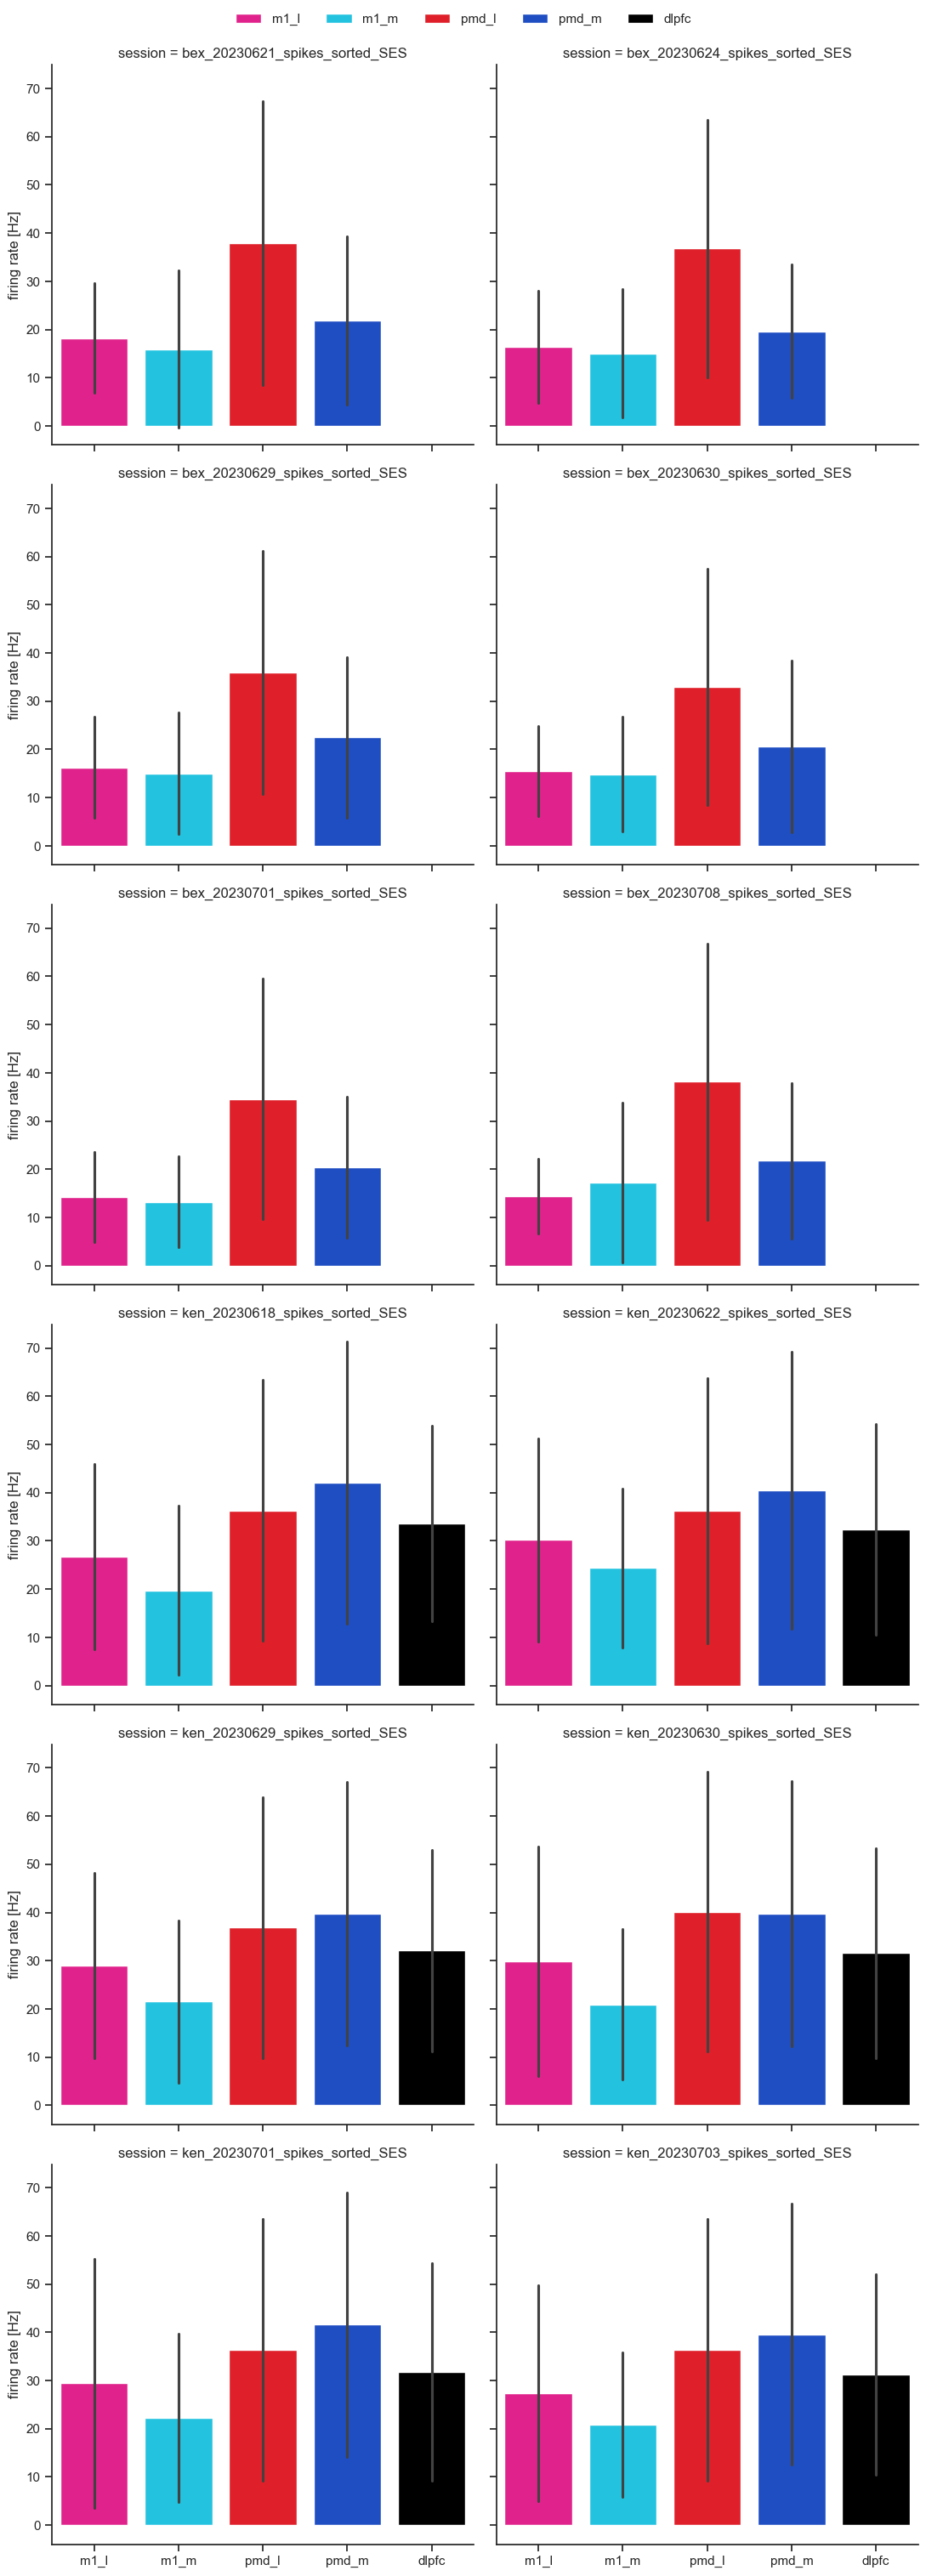

In [85]:
g = sns.catplot(
    data=firing_rates_df,
    col="session",
    hue="area",
    x="area",
    y="firing_rate",
    kind="bar",
    palette=PALETTE[:5],
    legend=True,
    errorbar="sd",
    col_wrap=2,
)
g.set_axis_labels("", "firing rate [Hz]")

legend = g._legend
handles = legend.legend_handles
labels = [t.get_text() for t in legend.get_texts()]
legend.remove()
g.fig.legend(
    handles,
    labels,
    bbox_to_anchor=(0.5, 1.005),
    loc="center",
    frameon=False,
    ncol=5,
    title="",
)
plt.tight_layout()